In [237]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [203]:
df_dev = pd.read_csv('dataset/development.csv')
df_eval = pd.read_csv('dataset/evaluation.csv')

df = pd.concat([df_dev, df_eval], sort=False)
df.head()

,id,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,weekday
0,0,http://mashable.com/2014/09/08/safest-cabbies-...,121.0,12.0,1015.0,0.422018,1.0,0.545031,10.0,6.0,...,-0.160714,-0.50,-0.071429,0.0,0.00,0.5,0.00,2900.0,bus,tuesday
1,1,http://mashable.com/2013/07/25/3d-printed-rifle/,532.0,9.0,503.0,0.569697,1.0,0.737542,9.0,0.0,...,-0.157500,-0.25,-0.100000,0.0,0.00,0.5,0.00,1300.0,tech,thursday
2,2,http://mashable.com/2013/10/30/digital-dinosau...,435.0,9.0,232.0,0.646018,1.0,0.748428,12.0,3.0,...,-0.427500,-1.00,-0.187500,0.0,0.00,0.5,0.00,17700.0,lifestyle,wednesday
3,3,http://mashable.com/2014/08/27/homer-simpson-i...,134.0,12.0,171.0,0.722892,1.0,0.867925,9.0,5.0,...,-0.216667,-0.25,-0.166667,0.4,-0.25,0.1,0.25,1500.0,bus,wednesday
4,4,http://mashable.com/2013/01/10/creepy-robotic-...,728.0,11.0,286.0,0.652632,1.0,0.800000,5.0,2.0,...,-0.251786,-0.50,-0.100000,0.2,-0.10,0.3,0.10,1400.0,tech,thursday


## Categorical data

### OneHot Encoding
- OneHot Encoding generates redundant data: if the ml model requires too much time to train itself or the model overfits, then the Effect Coding or Dummy Encoding could help to reduce the number of features.

In [204]:
enc = OneHotEncoder()
encoded_df = pd.concat([df_dev['weekday'], df_dev['data_channel']], axis=1)
enc.fit(encoded_df)
encoded_df = enc.transform(encoded_df)
additional_columns = enc.get_feature_names_out()
print(encoded_df.toarray().shape)
working_df_dev = df_dev.copy()
working_df_dev[additional_columns] = encoded_df.toarray()
working_df_dev.drop(['weekday', 'data_channel', 'url', 'id'], axis = 1, inplace=True)
working_df_dev

(31715, 13)


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,data_channel_bus,data_channel_entertainment,data_channel_lifestyle,data_channel_socmed,data_channel_tech,data_channel_world
0,121.0,12.0,1015.0,0.422018,1.0,0.545031,10.0,6.0,33.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,532.0,9.0,503.0,0.569697,1.0,0.737542,9.0,0.0,NaN,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,435.0,9.0,232.0,0.646018,1.0,0.748428,12.0,3.0,4.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,134.0,12.0,171.0,0.722892,1.0,0.867925,9.0,5.0,0.0,NaN,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,728.0,11.0,286.0,0.652632,1.0,0.800000,5.0,2.0,NaN,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31710,37.0,11.0,440.0,0.564103,1.0,0.718978,10.0,2.0,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31711,52.0,14.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31712,121.0,9.0,969.0,0.489583,1.0,0.710623,6.0,5.0,2.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
31713,503.0,11.0,1976.0,0.412308,1.0,0.621080,21.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Numerical data

### Feature selection based on correlation
- Features to delete (look at multivariate analysis):
    - n_unique_tokens
    - n_non_stop_words
    - kw_max_min
    - kw_min_max
    - kw_max_avg
    - abs_title_sentiment_polarity
    - abs_title_subjectivity
    - rate_positive_words 
    - timedelta
    - max_negative_polarity
    - min_negative_polarity
    - kw_min_min
    - kw_max_max
    - num_self_hrefs
    - n_tokens_content (to be verified)
    - data_channel_business
    - LDA_00

In [205]:
working_df_dev.drop(columns=['n_unique_tokens','n_non_stop_words','kw_max_min','kw_min_max','kw_max_avg','abs_title_sentiment_polarity',
                     'abs_title_subjectivity','rate_positive_words','timedelta','max_negative_polarity','min_negative_polarity',
                     'kw_min_min','kw_max_max','num_self_hrefs','data_channel_bus','LDA_00'], inplace=True)

In [206]:
working_df_dev.head()

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_avg_min,kw_avg_max,...,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,data_channel_entertainment,data_channel_lifestyle,data_channel_socmed,data_channel_tech,data_channel_world
0,12.0,1015.0,0.545031,10.0,33.0,1.0,4.656158,4.0,110.500000,398350.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.0,503.0,0.737542,9.0,NaN,1.0,4.576541,10.0,524.750000,117960.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9.0,232.0,0.748428,12.0,4.0,1.0,4.935345,6.0,198.666667,573878.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,12.0,171.0,0.867925,9.0,0.0,NaN,4.970760,6.0,444.166667,311033.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,11.0,286.0,0.800000,5.0,NaN,0.0,5.006993,NaN,356.200000,6830.125000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Feature selection based on univariate analysis
- Features to delete:
    - n_tokens_content: It can be observed that there are a lot of values equal to 0 words: this can be due to an error during the data collection step. As solution, we decide to drop the records corresponding to the value zero of this feature (3% of the whole dataset)
    - kw_avg_min: its distribution does not improve even after the preprocessing step
    - self_reference_min_shares: --> TO BE VERIFIED (its distribution does not improve even after the preprocessing step)
    - self_reference_max_shares: --> TO BE VERIFIED (its distribution does not improve even after the preprocessing step)
    - self_reference_avg_sharess: --> TO BE VERIFIED (its distribution does not improve even after the preprocessing step)
    - LDA_01: very low correlation with the dependent variable; it does not provide any important information
    - LDA_02: very low correlation with the dependent variable; it does not provide any important information
    - LDA_03: very low correlation with the dependent variable; it does not provide any important information
    - LDA_04: very low correlation with the dependent variable; it does not provide any important information
- Features to transform:
    - num_imgs: Filled NaN values with 0 and rescaled in logarithmic scale to better distribute data and remove outliers.
    - num_videos: Filled NaN values with 0 and rescaled in logarithmic scale to better distribute data and remove outliers.
    - n_tokens_content: Rescaled in logarithmic scale to better distribute data and remove outliers
    - avg_negative_polarity: Use absolute value to bring the range of this feature between [0, +1] as the corresponding "avg_positive_polarity" features
    - num_keywords: Filled NaN values with 0
    - num_hrefs: Rescaled in logarithmic scale to better distribute data
    - shares: Rescaled in logarithmic scale to better distribute data
    - kw_avg_avg: remove outliers using the quartiles; in this way the dataset is reduced by another 9%
    - weekdays: transform weekdays into a boolean status "isWeekend" since we've observed that the principal discrimination is based on weather the article is published on the weekend or not --> TO BE VERIFIED
- Features to scale:
    - n_tokens_content: standard scaler
    - n_tokens_title: standard scaler
    - kw_avg_min: standard scaler
    - kw_avg_max: standard scaler
    - kw_min_avg: standard scaler
    - kw_avg_avg: standard scaler
    - self_reference_min_shares: standard scaler
    - self_reference_max_shares: standard scaler
    - self_reference_avg_sharess: standard scaler

In [207]:
working_df_dev = working_df_dev.query("n_tokens_content > 0")

In [208]:
working_df_dev['n_tokens_content'] = np.log(working_df_dev['n_tokens_content'])

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_8889/420597367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['n_tokens_content'] = np.log(working_df_dev['n_tokens_content'])


In [209]:
working_df_dev['num_imgs'].fillna(0, inplace=True)
working_df_dev['num_imgs'] = np.log(1+working_df_dev['num_imgs'])

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_8889/4188442937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['num_imgs'].fillna(0, inplace=True)
/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_8889/4188442937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['num_imgs'] = np.log(1+working_df_dev['num_imgs'])


In [210]:
working_df_dev['num_videos'].fillna(0, inplace=True)
working_df_dev['num_videos'] = np.log(1+working_df_dev['num_videos'])

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_8889/1745796961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['num_videos'].fillna(0, inplace=True)
/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_8889/1745796961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['num_videos'] = np.log(1+working_df_dev['num_videos'])


In [211]:
std_scaler = StandardScaler().fit(working_df_dev[['n_tokens_title', 'n_tokens_content']])
scaled_features = std_scaler.transform(working_df_dev[['n_tokens_title', 'n_tokens_content']])
working_df_dev[['n_tokens_title', 'n_tokens_content']] = scaled_features

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_8889/1289566745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev[['n_tokens_title', 'n_tokens_content']] = scaled_features


In [212]:
working_df_dev['avg_negative_polarity'] = working_df_dev['avg_negative_polarity'].abs()

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_8889/4135121572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['avg_negative_polarity'] = working_df_dev['avg_negative_polarity'].abs()


In [213]:
working_df_dev['num_keywords'].fillna(0, inplace=True)

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_8889/619483132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['num_keywords'].fillna(0, inplace=True)


In [214]:
working_df_dev['shares'] = np.log(working_df_dev['shares'])

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_8889/1159595187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['shares'] = np.log(working_df_dev['shares'])


In [215]:
# Remove outliers from kw_avg_avg (we lost another 9% of the dataset)
q1 = working_df_dev['kw_avg_avg'].describe()['25%']
q3 = working_df_dev['kw_avg_avg'].describe()['75%']
iqr = q3 - q1
min_kw_avg_avg = q1 - 1.5*iqr
max_kw_avg_avg = q3 + 1.5*iqr
working_df_dev = working_df_dev[(df_dev.kw_avg_avg < max_kw_avg_avg) & (df_dev.kw_avg_avg > min_kw_avg_avg)]

working_df_dev.drop(columns=['kw_avg_min'], inplace=True)

std_scaler = StandardScaler().fit(working_df_dev[['kw_avg_max', 'kw_min_avg', 'kw_avg_avg']])
scaled_features = std_scaler.transform(working_df_dev[['kw_avg_max', 'kw_min_avg', 'kw_avg_avg']])
working_df_dev[['kw_avg_max', 'kw_min_avg', 'kw_avg_avg']] = scaled_features

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_8889/3959705728.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  working_df_dev = working_df_dev[(df_dev.kw_avg_avg < max_kw_avg_avg) & (df_dev.kw_avg_avg > min_kw_avg_avg)]


In [216]:
working_df_dev.drop(columns=['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess'], inplace=True)

'''
std_scaler = StandardScaler().fit(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])
scaled_features = std_scaler.transform(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])
working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']] = scaled_features
'''

"\nstd_scaler = StandardScaler().fit(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])\nscaled_features = std_scaler.transform(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])\nworking_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']] = scaled_features\n"

In [217]:
working_df_dev['num_hrefs'] = np.log(1 + working_df_dev['num_hrefs'])

In [218]:
# Drop LDA features because they are not well distributed even after the data preprocessing step...
# Maybe it's possible to check if the AdjR2_score experienced an increase when we add them
working_df_dev.drop(columns=['LDA_01', 'LDA_02', 'LDA_03', 'LDA_04'], inplace=True)

In [230]:
# Transform weekdays into a boolean status "isWeekend" since we've observed that the principal discrimination is based on
# weather the article is published on the weekend or not
is_weekend = []
for _, row in working_df_dev.iterrows():
    if row['weekday_sunday'] == 1 or row['weekday_saturday'] == 1:
        is_weekend.append(1)
    else:
        is_weekend.append(0)
working_df_dev['is_weekend'] = is_weekend
working_df_dev.drop(columns=[x for x in additional_columns if x.startswith('weekday')], inplace=True)

In [231]:
working_df_dev

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_avg_max,kw_min_avg,...,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,shares,data_channel_entertainment,data_channel_lifestyle,data_channel_socmed,data_channel_tech,data_channel_world,is_weekend
0,0.768992,1.182360,0.545031,2.397895,3.526361,0.693147,4.656158,4.0,1.129960,0.698238,...,0.160714,0.000000,0.000000,7.972466,0.0,0.0,0.0,0.0,0.0,0
1,-0.649891,0.213789,0.737542,2.302585,0.000000,0.693147,4.576541,10.0,-1.027350,-0.965816,...,0.157500,0.000000,0.000000,7.170120,0.0,0.0,0.0,1.0,0.0,0
2,-0.649891,-0.853837,0.748428,2.564949,1.609438,0.693147,4.935345,6.0,2.480468,-0.087832,...,0.427500,0.000000,0.000000,9.781320,0.0,1.0,0.0,0.0,0.0,0
3,0.768992,-1.274725,0.867925,2.302585,0.000000,0.000000,4.970760,6.0,0.458149,0.944244,...,0.216667,0.400000,-0.250000,7.313220,0.0,0.0,0.0,0.0,0.0,0
4,0.296031,-0.565145,0.800000,1.791759,0.000000,0.000000,5.006993,0.0,-1.882379,-0.965816,...,0.251786,0.200000,-0.100000,7.244228,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31709,0.296031,0.254330,0.703008,2.302585,0.693147,0.693147,4.372587,0.0,-0.231487,2.207003,...,0.386310,0.288889,-0.155556,6.527958,0.0,1.0,0.0,0.0,0.0,0
31710,0.296031,0.029174,0.718978,2.397895,0.000000,0.000000,4.784091,5.0,0.038879,0.502769,...,0.209167,0.000000,0.000000,6.907755,0.0,0.0,0.0,0.0,1.0,0
31712,-0.649891,1.118374,0.710623,1.945910,1.098612,0.693147,4.594427,8.0,-0.312466,-0.965816,...,0.400000,0.000000,0.000000,7.783224,0.0,0.0,0.0,1.0,0.0,0
31713,0.296031,2.101447,0.621080,3.091042,0.693147,1.386294,4.353239,10.0,0.187219,1.580256,...,0.323413,0.700000,-0.400000,8.699515,0.0,1.0,0.0,0.0,0.0,0


In [232]:
working_df_dev.describe()

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_avg_max,kw_min_avg,...,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,shares,data_channel_entertainment,data_channel_lifestyle,data_channel_socmed,data_channel_tech,data_channel_world,is_weekend
count,29450.000000,29450.000000,29450.000000,29450.000000,29450.000000,29450.000000,29450.000000,29450.000000,2.945000e+04,2.945000e+04,...,29450.000000,29450.000000,29450.000000,29450.000000,29450.000000,29450.000000,29450.000000,29450.000000,29450.000000,29450.000000
mean,0.001093,0.012689,0.694141,2.206863,0.879087,0.313204,4.685439,5.762886,-1.930167e-17,3.812080e-17,...,0.265254,0.275924,0.069097,7.447231,0.181800,0.174058,0.061358,0.197657,0.219117,0.130390
std,1.001825,0.999471,0.100552,0.719399,0.949518,0.631295,0.279909,3.349513,1.000017e+00,1.000017e+00,...,0.119860,0.320867,0.260960,0.906247,0.385686,0.379166,0.239990,0.398239,0.413655,0.336738
min,-3.960618,-4.380663,0.123214,0.000000,0.000000,0.000000,3.600000,0.000000,-1.911727e+00,-9.667361e-01,...,0.000000,0.000000,-1.000000,1.609438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.649891,-0.686065,0.633333,1.791759,0.000000,0.000000,4.496471,4.000000,-6.321786e-01,-9.658163e-01,...,0.191667,0.000000,0.000000,6.844815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.176930,-0.012202,0.694444,2.197225,0.693147,0.000000,4.673808,6.000000,-1.044337e-01,-7.893995e-02,...,0.255357,0.100000,0.000000,7.244228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.768992,0.731411,0.757576,2.639057,1.098612,0.693147,4.859056,8.000000,5.520134e-01,8.416499e-01,...,0.328562,0.500000,0.136364,7.901007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.971563,4.110082,1.000000,5.720312,4.859812,4.330733,8.041534,10.000000,4.553388e+00,2.354911e+00,...,1.000000,1.000000,1.000000,13.645078,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Other final adjustments based on the final result of this step

<Axes: >

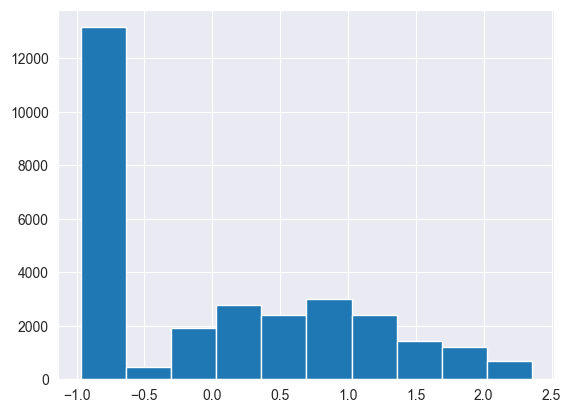

In [197]:
working_df_dev['kw_min_avg'].hist()

20468 31715


array([[<Axes: title={'center': 'num_imgs'}>]], dtype=object)

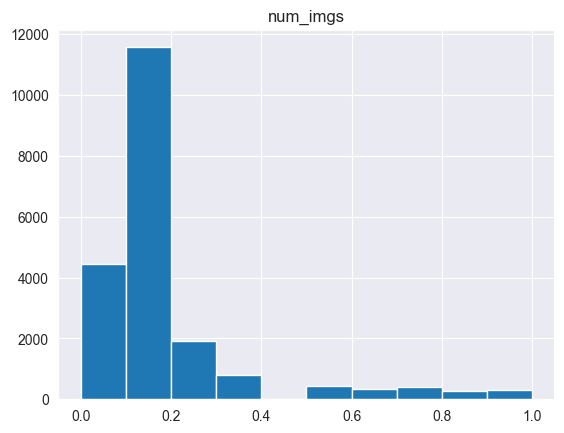

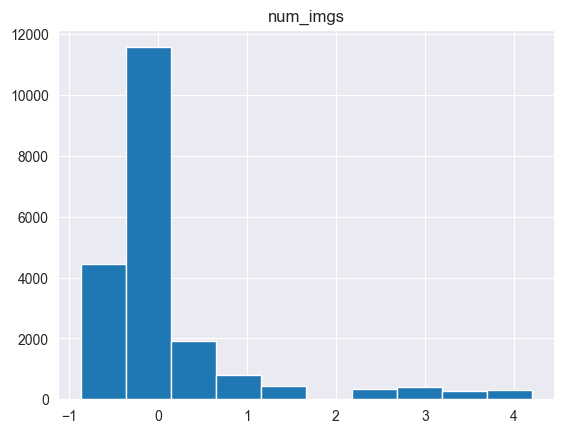

In [107]:
# remove outlier from num_imgs and see if the distribution improve
# se tagliamo fuori gli outliers usando i percentili si distribuisce meglio ma stiamo tagliando fuori il 20% del dataset
from sklearn.preprocessing import MinMaxScaler

q1 = df_dev['num_imgs'].describe()['25%']
q3 = df_dev['num_imgs'].describe()['75%']
iqr = q3 - q1
min_num_imgs = q1 - 1.5*iqr
max_num_imgs = q3 + 1.5*iqr
new_df_imgs = df_dev[(df_dev.num_imgs < max_num_imgs) & (df_dev.num_imgs > min_num_imgs)]
print(len(new_df_imgs), len(df_dev))

pd.DataFrame(data=MinMaxScaler(feature_range=(0, 1)).fit_transform(new_df_imgs[['num_imgs']]), columns=['num_imgs']).hist()
pd.DataFrame(data=StandardScaler().fit_transform(new_df_imgs[['num_imgs']]), columns=['num_imgs']).hist()
#pd.DataFrame(data=MinMaxScaler(feature_range=(0, 1)).fit_transform(df_dev[['num_imgs']]), columns=['num_imgs']).hist()
#pd.DataFrame(data=StandardScaler().fit_transform(df_dev[['num_imgs']]), columns=['num_imgs']).hist()

29994 31715
0.9457354564086394


<Axes: >

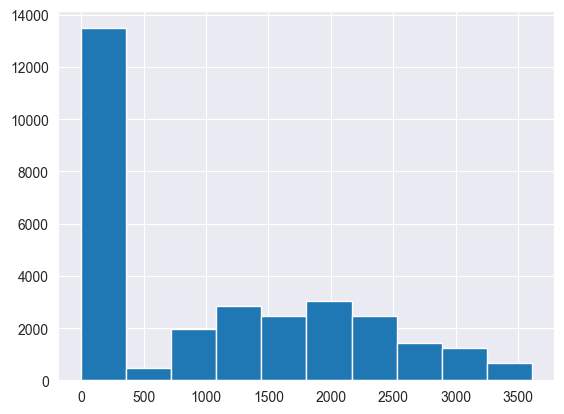

In [129]:
q1 = df_dev['kw_min_avg'].describe()['25%']
q3 = df_dev['kw_min_avg'].describe()['75%']
iqr = q3 - q1
min_kw_avg_avg = q1 - 1.5*iqr
max_kw_avg_avg = q3 + 1.5*iqr
new_df_kw_avg_avg = df_dev[(df_dev.kw_avg_avg < max_kw_avg_avg) & (df_dev.kw_avg_avg > min_kw_avg_avg)]
print(len(new_df_kw_avg_avg), len(df_dev))
print(len(new_df_kw_avg_avg) / len(df_dev))
new_df_kw_avg_avg['kw_min_avg'].hist()
#df_dev['kw_avg_avg'].hist()

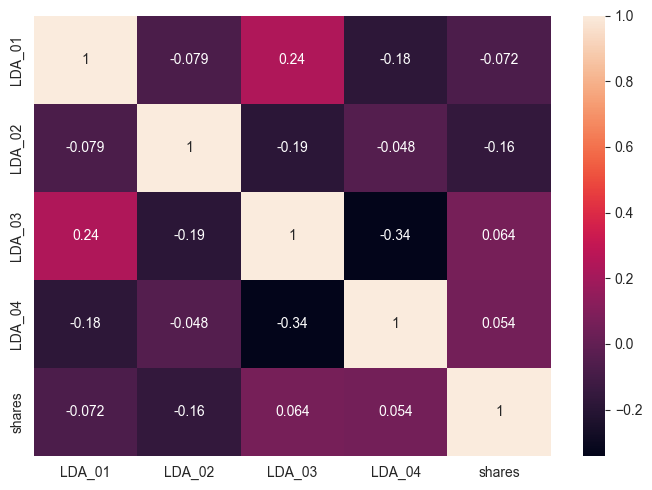

In [145]:
import seaborn as sns

lda = ['LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'shares']

_, ax = plt.subplots(1,1, figsize=(7, 5))
sns.heatmap(working_df_dev[lda].corr(method='spearman').loc[lda], ax=ax, annot=True)
plt.tight_layout()
plt.show()

## Features importance

### Features selected based on the importance
- Use RandomForestRegression to discover the features importance in order to predict the target variable
- The OneHot-Encoding features have a lower importance... It is possibile to try to delete them
- Without the OneHot-Encoding features the RMSE is higher and this means a worse result

In [233]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [234]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train , y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
r2 = r2_score(y_valid, reg.predict(X_valid))
adj_r2 = 1-(1-r2)*(len(X_valid) - 1)/(len(X_valid) - X_valid.shape[1] - 1)
print(adj_r2)

0.8363469097163312
0.11501655157110602


In [235]:
feature_names = working_df_dev.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('kw_avg_avg', 0.12374509164943762),
 ('kw_avg_max', 0.06732004205865229),
 ('n_non_stop_unique_tokens', 0.057257222634345316),
 ('global_subjectivity', 0.0560922663830787),
 ('average_token_length', 0.055332441617790634),
 ('n_tokens_content', 0.0552762844887399),
 ('avg_positive_polarity', 0.049839097566336074),
 ('avg_negative_polarity', 0.04819814402850409),
 ('num_hrefs', 0.046726102630046944),
 ('global_sentiment_polarity', 0.04596910401839951),
 ('global_rate_positive_words', 0.045539572000351136),
 ('global_rate_negative_words', 0.04217745861885641),
 ('kw_min_avg', 0.0395465511862795),
 ('rate_negative_words', 0.03334485226787265),
 ('n_tokens_title', 0.030863167916486314),
 ('title_sentiment_polarity', 0.03046895060139374),
 ('title_subjectivity', 0.023202687654565117),
 ('num_imgs', 0.023110462912571756),
 ('num_keywords', 0.021691585501345322),
 ('min_positive_polarity', 0.020922818464311124),
 ('num_videos', 0.015654599333648545),
 ('max_positive_polarity', 0.015402363233

#### Without OneHot-Encoded features

In [198]:
working_df_dev_no_onehot = working_df_dev.drop(columns=['data_channel_world', 'weekday_friday', 'weekday_wednesday',
                                                        'weekday_thursday', 'data_channel_lifestyle', 'weekday_tuesday',
                                                        'weekday_monday', 'data_channel_socmed', 'weekday_sunday', 'data_channel_tech',
                                                        'data_channel_entertainment', 'weekday_saturday'])

X = working_df_dev_no_onehot.drop(columns=["shares"]).values
y = working_df_dev_no_onehot["shares"].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [199]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train , y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
r2 = r2_score(y_valid, reg.predict(X_valid))
adj_r2 = 1-(1-r2)*(len(X_valid) - 1)/(len(X_valid) - X_valid.shape[1] - 1)
print(adj_r2)

0.8527091366072734
0.08080233235922296


In [60]:
feature_names = working_df_dev_no_onehot.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('kw_avg_avg', 0.11044895690775566),
 ('self_reference_avg_sharess', 0.04926776474511304),
 ('kw_avg_max', 0.047355415176575266),
 ('kw_avg_min', 0.04374766267911385),
 ('n_non_stop_unique_tokens', 0.04230917542764838),
 ('LDA_01', 0.03979648738535886),
 ('LDA_04', 0.03946678694668837),
 ('n_tokens_content', 0.03915448765787121),
 ('average_token_length', 0.038543912739106165),
 ('global_subjectivity', 0.038425300204354654),
 ('LDA_02', 0.037130928033989555),
 ('LDA_03', 0.03711095942000228),
 ('avg_positive_polarity', 0.0356730903177886),
 ('avg_negative_polarity', 0.03550492933578567),
 ('self_reference_min_shares', 0.0343583856022983),
 ('global_rate_positive_words', 0.03362383617265644),
 ('global_sentiment_polarity', 0.033298827748174845),
 ('num_hrefs', 0.032537821566620634),
 ('global_rate_negative_words', 0.029827182624030144),
 ('kw_min_avg', 0.029168613010562956),
 ('rate_negative_words', 0.02469459618733489),
 ('self_reference_max_shares', 0.02252662737095779),
 ('title_sen

#### Continue to delete features with low importance

In [79]:
working_df_dev_reducted = working_df_dev_no_onehot.drop(columns=['self_reference_min_shares', 'self_reference_max_shares', 'kw_min_avg', 'kw_avg_avg',
                                                            'min_positive_polarity', 'max_positive_polarity', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04'])

X = working_df_dev_reducted.drop(columns=["shares"]).values
y = working_df_dev_reducted["shares"].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [81]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train , y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
print(r2_score(y_valid, reg.predict(X_valid)))

0.8774152875040087
0.08025443770674512


In [77]:
feature_names = working_df_dev_reducted.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('self_reference_avg_sharess', 0.09874496329273745),
 ('kw_avg_max', 0.06308988012270815),
 ('kw_avg_min', 0.0609908405212075),
 ('n_non_stop_unique_tokens', 0.05786302241558468),
 ('average_token_length', 0.057381221043681006),
 ('global_subjectivity', 0.056455306456974864),
 ('n_tokens_content', 0.05554684669724463),
 ('avg_positive_polarity', 0.05353840853426568),
 ('global_rate_positive_words', 0.049381579200996804),
 ('avg_negative_polarity', 0.04915682038521308),
 ('num_hrefs', 0.04658050074205566),
 ('global_sentiment_polarity', 0.04490124003615786),
 ('global_rate_negative_words', 0.04289293018713305),
 ('rate_negative_words', 0.034479842755919754),
 ('title_sentiment_polarity', 0.03058223415713801),
 ('n_tokens_title', 0.029041857796420895),
 ('num_imgs', 0.025904649606108335),
 ('title_subjectivity', 0.0239993375816882),
 ('num_keywords', 0.022454375720673606),
 ('num_videos', 0.014392338823224892),
 ('data_channel_world', 0.013364319186322693),
 ('data_channel_entertainment

### Features selection with PCA
- We just need from 8 to 16 Principal Components (PCs) in order to cover the cumulative explain variance of the dataset

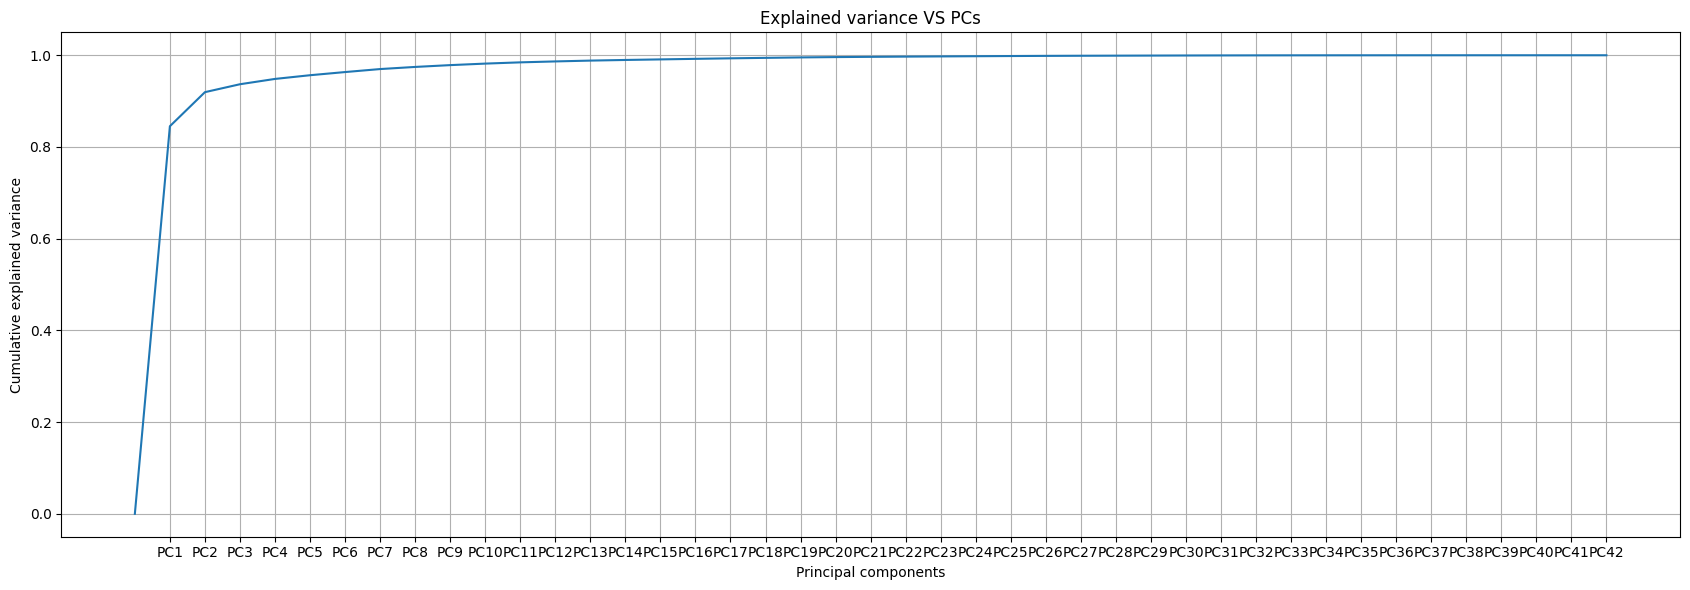

In [31]:
X = working_df_dev.drop(columns=["shares"]).values

pca_1 = PCA(random_state = 42)
pca_1.fit(X)

fig, ax = plt.subplots(1,1, figsize = (17,6))
ax.plot(np.insert(np.cumsum(pca_1.explained_variance_ratio_), 0, 0))
ax.set_title('Explained variance VS PCs')
plt.xticks(ticks=np.arange(1, pca_1.n_features_in_ + 1),
           labels=[f'PC{i}' for i in range(1, pca_1.n_features_in_ + 1)])
ax.set_xlabel('Principal components')
ax.set_ylabel('Cumulative explained variance')
ax.grid()
plt.tight_layout()
plt.show()

In [32]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

pca_12 = PCA(n_components=12, random_state = 42)
pca_12.fit(X)

X_train, X_valid, y_train, y_valid = train_test_split(pca_12.transform(X), y, shuffle=True, random_state=42)

In [36]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train, y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
print(r2_score(y_valid, reg.predict(X_valid)))

0.8688872188329296
0.09804654845413274


In [37]:
feature_names = working_df_dev.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('n_non_stop_unique_tokens', 0.13454098707910733),
 ('n_tokens_title', 0.09790095070118207),
 ('kw_avg_avg', 0.08935787403970165),
 ('kw_min_avg', 0.08213931339881514),
 ('num_imgs', 0.08126376535984962),
 ('num_videos', 0.08025253501825359),
 ('num_keywords', 0.07564481820096851),
 ('n_tokens_content', 0.07548242160043558),
 ('average_token_length', 0.07449868077618106),
 ('kw_avg_min', 0.07423015669010685),
 ('num_hrefs', 0.06985958281557146),
 ('kw_avg_max', 0.06482891431982697)]

In [39]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

pca_16 = PCA(n_components=16, random_state = 42)
pca_16.fit(X)

X_train, X_valid, y_train, y_valid = train_test_split(pca_16.transform(X), y, shuffle=True, random_state=42)
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train, y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
print(r2_score(y_valid, reg.predict(X_valid)))

0.8606521973872098
0.11506235367672135


## Polynomial regressor

In [238]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [245]:
pipe = make_pipeline(
    PolynomialFeatures(2),
    Lasso(alpha=0.4)
)
pipe.fit(X_train, y_train)
'''
poli = PolynomialFeatures(2)
poli_train = poli.fit_transform(X_train)
poli_test = poli.fit_transform(X_valid)

reg = LinearRegression()
reg.fit(poli_train, y_train)
preds_poli_reg = reg.predict(poli_test)
'''
preds_poli_reg = pipe.predict(X_valid)

rms = mean_squared_error(y_valid, preds_poli_reg, squared=False)
print(rms)
r2 = r2_score(y_valid, reg.predict(X_valid))
adj_r2 = 1-(1-r2)*(len(X_valid) - 1)/(len(X_valid) - X_valid.shape[1] - 1)
print(adj_r2)

0.8679914062455072
0.11501655157110602
